Paul writes:
 - Cosmos to full depth: hsc-1361/20151104/cosmos
 - Cosmos to wide depth with interleaved exposures: hsc-1361/20151104/cosmos[12]
 - Two tracts of wide: hsc-1361/20151104/wide

In [1]:
import numpy as np
import lsst.daf.persistence as dafPersist
import lsst.afw.display.ds9 as ds9
import lsst.afw.display.utils as ds9Utils
import lsst.afw.display.rgb as afwRgb
import lsst.afw.geom as afwGeom
import lsst.afw.coord as afwCoord
import lsst.afw.math as afwMath
import lsst.afw.image as afwImage
import lsst.afw.table as afwTable

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (8, 8)

In [2]:
import os
butler = dafPersist.Butler(os.path.join(os.environ["SUPRIME_DATA_DIR"], "rerun",
    "hsc-1361/20151104/cosmos"))

In [3]:
dataId = dict(tract=0, patch='5,5', filter='HSC-I', sfilter='i')
coadd = butler.get("deepCoadd_calexp", dataId, immediate=True)

In [4]:
frame = 0
if 1:
    ds9.mtv(coadd, title=str(dataId)[1:-1], frame=frame)

In [5]:
meas = butler.get("deepCoadd_meas", dataId)

print "%d sources, of which %d are sky" % (
    len(meas), np.sum(meas.get('merge.footprint.sky')))

32643 sources, of which 99 are sky


In [6]:
if 1:
    ds9.erase(frame=frame)
    with ds9.Buffering():
        for s in meas:
            ds9.dot('+' if s.get('merge.peak.%s' % dataId["sfilter"]) else 'x',
                    s.getX() - coadd.getX0(), s.getY() - coadd.getY0(), size=3, 
                    ctype=ds9.RED, frame=frame)
    with ds9.Buffering():
        for s in meas[meas['merge.peak.sky']]:
            ds9.dot('o', s.getX() - coadd.getX0(), s.getY() - coadd.getY0(), size=12,
                    ctype=ds9.CYAN, frame=frame)
    if False:
        with ds9.Buffering():
            for s in meas[meas['detect.is-primary']]:
                ds9.dot('o', s.getX() - coadd.getX0(), s.getY() - coadd.getY0(), size=10,
                        ctype=ds9.GREEN, frame=frame)

Plot histograms of blendedness.abs.flux and blendedness.raw.flux

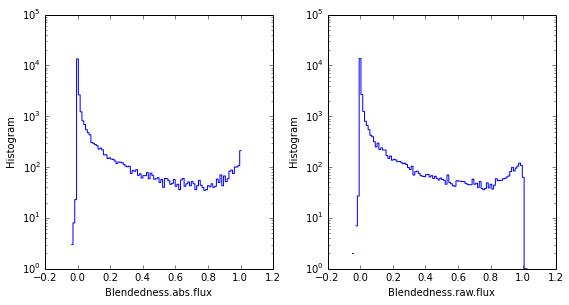

In [7]:
ax = plt.subplot(221)
ax.hist(meas['blendedness.abs.flux'], 100, range=(-0.05, 1.05), histtype='step')
ax.set_yscale('log')
ax.set_xlabel("Blendedness.abs.flux")
ax.set_ylabel("Histogram")

ax = plt.subplot(222)
ax.hist(meas['blendedness.raw.flux'], 100, range=(-0.05, 1.05), histtype='step')
ax.set_yscale('log')
ax.set_xlabel("Blendedness.raw.flux")
ax.set_ylabel("Histogram")
plt.tight_layout()

These mostly look similar. This should be the case for objects which are bright and above the noise limit. It is strange that there is a rise in blendedness near unity. This must be due to the fake detections near bright objects. Perhaps blendedness is a good way to get rid of these objects, but currently no way to know if the real objects have a different blendedness distribution from the fake objects.

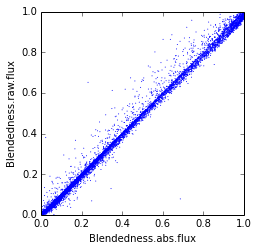

In [8]:
b_abs = meas['blendedness.abs.flux']
b_raw = meas['blendedness.raw.flux']
ax = plt.subplot(221)
ax.scatter(b_abs, b_raw, s=1, lw=0)
ax.set_xlim([0, 1])
ax.set_ylim([0, 1])
ax.set_xlabel("Blendedness.abs.flux")
ax.set_ylabel("Blendedness.raw.flux")

Mostly one to one, there is a small upscatter in the values of blendedness.raw.flux compared to blendedness.abs.flux. I think we can just go with the latter. Let us get some statistics

In [9]:
# Check what fraction is nan
nan_abs = np.sum(np.isnan(b_abs))*100.0/b_abs.size
nan_raw = np.sum(np.isnan(b_raw))*100.0/b_raw.size

print("Percentage of blendedness.abs.flux nans: %.3f" % nan_abs )
print("Percentage of blendedness.raw.flux nans: %.3f" % nan_raw )

idx_abs = np.logical_not(np.isnan(b_abs))
idx_raw = np.logical_not(np.isnan(b_raw))

print "This should be zero if NANs are shared by blendedness.abs.flux and blendedness.raw.flux : ", np.sum(idx_abs!=idx_raw)
idx = np.logical_not(np.isnan(b_abs))

# Some statistics
fail_abs = np.sum((b_abs[idx]<0.0) | (b_abs[idx]>1.0))*100.0/b_abs[idx].size
fail_raw = np.sum((b_raw[idx]<0.0) | (b_raw[idx]>1.0))*100.0/b_raw[idx].size

print("Percentage of blendedness.abs.flux out of bounds: %.3f" % fail_abs )
print("Percentage of blendedness.raw.flux out of bounds: %.3f" % fail_raw )

Percentage of blendedness.abs.flux nans: 14.582
Percentage of blendedness.raw.flux nans: 14.582
This should be zero if NANs are shared by blendedness.abs.flux and blendedness.raw.flux :  0
Percentage of blendedness.abs.flux out of bounds: 1.119
Percentage of blendedness.raw.flux out of bounds: 1.259


Large fraction of objects have nans. Let us check what blendedness flags they received.

In [10]:
# Check flags
flags_noShape=meas['blendedness.flags.noShape']
flags_noCentroid=meas['blendedness.flags.noCentroid']

print("Percentage of flagged objects with noShape : %.3f" % (np.sum(flags_noShape)*100./flags_noShape.size))
print("Percentage of flagged objects with noCentroid : %.3f" % (np.sum(flags_noCentroid)*100./flags_noCentroid.size))

print("Zero if all NANs are flagged as having noShape : %.3f " %(np.sum( np.isnan(b_abs) & (flags_noShape==0) )))

print("Zero if all NANs are flagged as having noCentroid : %.3f " %(np.sum( np.isnan(b_abs) & (flags_noCentroid==0) )))

Percentage of flagged objects with noShape : 14.582
Percentage of flagged objects with noCentroid : 7.864
Zero if all NANs are flagged as having noShape : 0.000 
Zero if all NANs are flagged as having noCentroid : 3520.000 


All NANs are due to bad shape!

Compare old deblendedness to the new one!

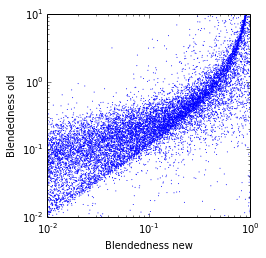

In [31]:
b_old = meas['blendedness.old']

idxold = (b_old>0.0) & (b_old<10.0)

ax = plt.subplot(221)
ax.scatter((b_abs[idx & idxold]), (b_old[idx & idxold]), s=1, lw=0)
ax.set_xlim([0.01, 1])
ax.set_ylim([0.01, 10])
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylabel("Blendedness old")
ax.set_xlabel("Blendedness new")

So it seems there some connection between the old and new blendedness definitions as expected, but there is quite some scatter.

In [32]:
class Cmap(object):
    """An object to take a matplotlib colourmap name and return a ds9-compliant ctype
    
    E.g.
       cmap = Cmap("rainbow", (0, 1))
       ds9.dot('o', s.getX(), s.getY(), ctype=cmap.ctype(s['blendedness.abs.flux'])
    """
    def __init__(self, cmapName="rainbow", range=(0, 1)):
        self._cmap = plt.get_cmap(cmapName)
        self.N = self._cmap.N
        self._min = range[0]
        self._scale = (self.N - 1)/float(range[1] - range[0])
        
    def ctype(self, value):
        if not np.isfinite(value):
            color = (0.0, 0.0, 0.0)
        else:
            color = self._cmap(int(self._scale*(value - self._min)))
            
        return '#%04x%04x%04x' % (65535*color[0], 65535*color[1], 65535*color[2])

In [50]:
cmap = Cmap("rainbow", (0, 0.25))

ds9.erase()
with ds9.Buffering():
    for s in meas:
        if s['parent'] != 0 and s['blendedness.abs.flux']<0.5:
            ds9.dot('o', s.getX() - coadd.getX0(), s.getY() - coadd.getY0(), size=10, 
                        ctype=cmap.ctype(s['blendedness.abs.flux']), frame=frame)

In [ ]:
# Now get the magnitudes and check deblendedness as a function of magnitude

md = butler.get("deepCoadd_calexp_md", dataId)
fluxmag0 = md.get("FLUXMAG0")
cmodel_flux = meas['cmodel.flux']
cmodel_mag = -2.5*np.log10(cmodel_flux/fluxmag0)
print cmodel_mag

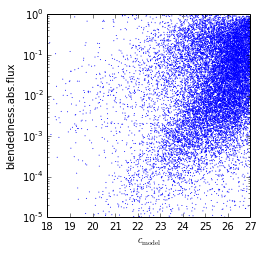

In [55]:
ax = plt.subplot(221)
ax.scatter(cmodel_mag, b_abs, s=1, lw=0)
ax.set_ylim([1e-5, 1])
ax.set_xlim([18.0, 27.0])
ax.set_yscale("log")
ax.set_xlabel(r"$c_{\rm model}$")
ax.set_ylabel("blendedness.abs.flux")